#### import modules

In [8]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import loadmat
import tensorflow as tf

plt.style.use("ggplot")
%matplotlib inline

In [9]:
# each sample lasts 30 seconds (sampling rate: 100 Hz)
eeg_data = loadmat("./eeg_data.mat")
X = eeg_data['X_train']
y = eeg_data['y_train']

In [10]:
# five labels for each sleep stage
print(np.unique(y))

['N1' 'N2' 'N3' 'R ' 'W ']


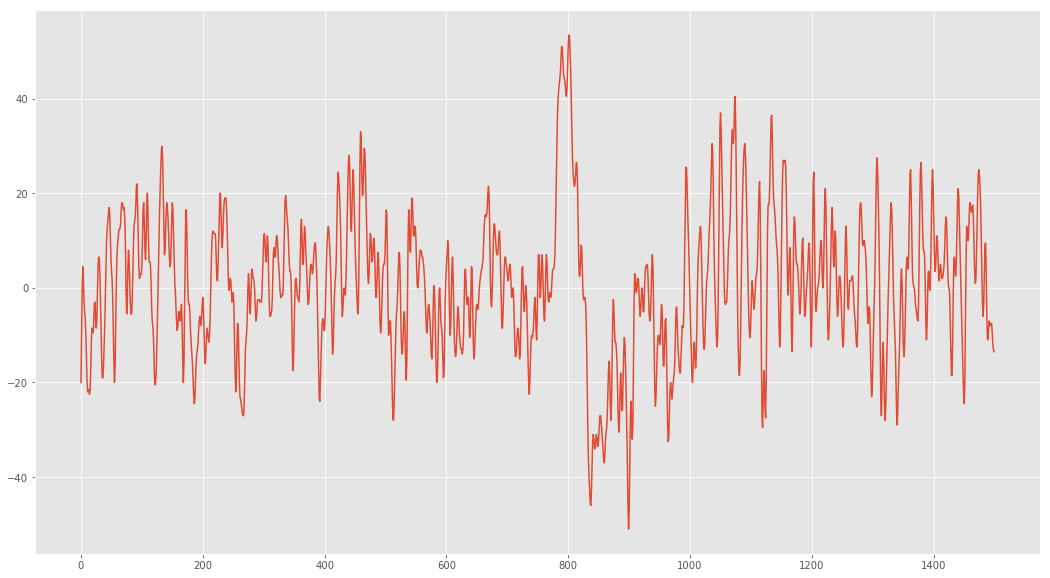

In [13]:
fig, ax = plt.subplots(figsize=(18, 10))
plt.plot(X[0][:1500])

## CNN architecture